# 模拟退火 Simulated Annealing

xyfJASON

## 1 概述

定义状态 $i$ 的能量为 $E(i)$，在温度 $T$ 下，从状态 $i$ 进入状态 $j$ 遵循如下规律：

- 若 $E(j)\leqslant E(i)$​，则接受该转换；

- 否则，以如下概率接受转换：
  $$
  e^\frac{E(i)-E(j)}{KT}
  $$
  其中，$K$ 在物理意义上是玻尔兹曼常数，但在算法实现中我们取 $K=1$ 即可。

在**特定温度**下，充分次转换后状态的概率分布达到平衡（玻尔兹曼分布）：
$$
P_T(X=i)=\frac{\exp\left(-\frac{E(i)}{KT}\right)}{\sum\limits_{j\in S}\exp\left(-\frac{E(j)}{KT}\right)}
$$
容易知道，当 $T$ 很大时，该分布区倾向于均匀分布，即每种状态等可能出现；而当 $T$ 很小时，该分布倾向于集中在能量最低的状态上，即有很大概率进入能量最小状态。

综上，模拟退火算法步骤如下：

1. 设定初始温度、结束温度、降温比率、能量函数
2. 设定初始状态和状态转换规则，要求当前状态只依赖于前一个状态
3. 在当前温度下按照接受概率进行若干次状态转换
4. 降温
5. 重复 3、4 步骤直至温度低于结束温度

**因此，要用模拟退火算法解决一个实际问题，最关键的步骤是设计好状态表示、能量函数和状态转换规则。**

## 2 代码模板

见同文件夹下的 `modopt.py` 模块。

## 3 例题

### 3.1 例一——旅行商问题（TSP）

http://www.math.uwaterloo.ca/tsp/vlsi/index.html

模拟退火算法解 TSP 问题：

- 状态表示：城市编号序列，依次按照序列顺序访问城市
- 能量函数：路径长度
- 状态转换规则：在当前序列中随机选择一段连续自序列，翻转并插入回原位置

读入数据文件，计算距离矩阵：

In [1]:
import numpy as np
import random

with open('data/tsp_data.txt') as f:
    data = [list(map(int, line.strip().split())) for line in f.readlines()]
    data = np.array(data)
n = 131

dist_mat = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        dist_mat[i, j] = np.sqrt(np.sum((data[i, 1:] - data[j, 1:]) ** 2))

继承 `SimulatedAnnealing` 类，重写方法，包括：定义初始状态和初始能量、定义状态和能量的转换规则

In [2]:
from modopt import SimulatedAnnealing

class Solver(SimulatedAnnealing):
        def gen_init_state_energy(self) -> tuple[np.ndarray, float]:
            best_init_state, best_init_energy = np.arange(n), np.inf
            for _ in range(10):
                init_state = np.concatenate(([0], np.random.permutation(n-1)+1))
                init_energy = sum([dist_mat[init_state[i], init_state[(i+1)%n]] for i in range(n)])
                if init_energy < best_init_energy:
                    best_init_state, best_init_energy = init_state, init_energy
            return best_init_state, best_init_energy

        def next_state_energy(self, cur_state: np.ndarray, cur_energy: float) -> tuple[np.ndarray, float]:
            u, v = random.sample(range(n), k=2)
            u, v = (v+1, u+1) if u > v else (u+1, v+1)  # u, v both are in [1, n]
            
            next_state = cur_state.copy()
            next_state[u:v] = next_state[u:v][::-1]  # [u, v)
            
            next_energy = cur_energy
            next_energy += dist_mat[next_state[u-1], next_state[u]]
            next_energy += dist_mat[next_state[v-1], next_state[v%n]]
            next_energy -= dist_mat[next_state[u-1], next_state[v-1]]
            next_energy -= dist_mat[next_state[u], next_state[v%n]]
            
            return next_state, next_energy

设定初始温度为 $100$，结束温度为 $10^{-30}$，冷却系数为 $0.999$，每个温度下迭代 $10$ 次，运行模拟退火：

In [3]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

solver = Solver(init_T=100,
                end_T=1e-30,
                cool_factor=0.999,
                steps_per_T=10)
res = solver.run()
res

100%|█████████████████████████████████| 73646/73646.0 [00:10<00:00, 6985.34it/s]


(array([  0,   5,  11,   4,  12,  17,  13,  14,  15,  16,  24,  18,  19,
         20,  32,  31,  30,  29,  28,  27,  26,  25,  52,  44,  45,  53,
         54,  74,  76,  67,  63,  73,  88,  97,  92,  91,  93,  98, 101,
        100,  99, 111, 122, 129, 130, 125, 124, 123, 120, 117, 113, 104,
        105, 106, 112, 107, 108, 114, 118, 126, 127, 128, 119, 115, 109,
        110, 116, 121, 102, 103,  96,  95,  94,  90,  89,  85,  84,  83,
         79,  82,  87,  86,  81,  80,  77,  68,  64,  61,  46,  47,  48,
         49,  50,  51,  56,  55,  65,  69,  78,  75,  70,  66,  62,  57,
         71,  72,  58,  59,  60,  43,  42,  41,  40,  39,  38,  37,  36,
         35,  34,  33,  21,  22,  23,  10,   3,   9,   8,   2,   1,   7,
          6]),
 610.7878123797989)

作出能量（距离）变化的历史曲线和历史最佳曲线：

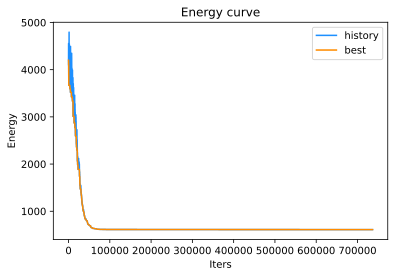

In [4]:
solver.plot()

绘制路线图：

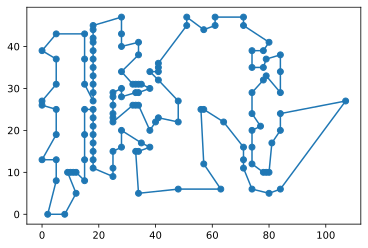

In [5]:
def plot_route(res_state):
    fig, ax = plt.subplots(1, 1)
    ax.scatter(data[:, 1], data[:, 2])
    ax.plot(np.hstack((data[res_state, 1], data[res_state[0:1], 1])),
            np.hstack((data[res_state, 2], data[res_state[0:1], 2])))
    plt.show()

plot_route(res[0])

### 3.2 例二

求下列函数在 $[-3,3]^2$ 上的最大值：

$$
F(x,y)=3(1-x)^2e^{-x^2-(y+1)^2}-10\left(\frac{x}{5}-x^3-y^5\right)e^{-x^2-y^2}-\frac{1}{3}^{\exp\left(-(x+1)^2-y^2\right)}
$$

代码如下：

In [6]:
def F(x, y):
    return 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2)-10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3**np.exp(-(x+1)**2-y**2)

class Solver(SimulatedAnnealing):
    def gen_init_state_energy(self) -> tuple[np.ndarray, float]:
        return np.array([0, 0]), -F(0, 0)

    def next_state_energy(self, cur_state: np.ndarray, cur_energy: float) -> tuple[np.ndarray, float]:
        next_state = cur_state + np.random.randn(2) / 10.
        next_state = np.clip(next_state, [-3, -3], [3, 3])
        return next_state, -F(next_state[0], next_state[1])

solver = Solver(init_T=100,
                end_T=1e-30,
                cool_factor=0.999,
                steps_per_T=1)
res = solver.run()
res[0], -res[1]

100%|████████████████████████████████| 73646/73646.0 [00:03<00:00, 21485.25it/s]


(array([-0.01465715,  1.57674526]), 7.15019373350287)

作出能量（函数值）变化的历史曲线和历史最佳曲线：

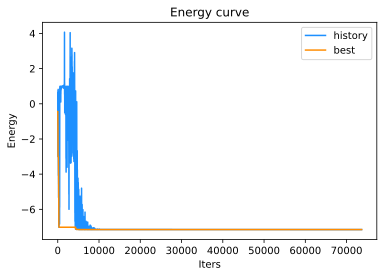

In [7]:
solver.plot()

作图如下：
![](img/sa.png)